Using device: cuda


100%|██████████| 500/500 [00:00<00:00, 909.19it/s]


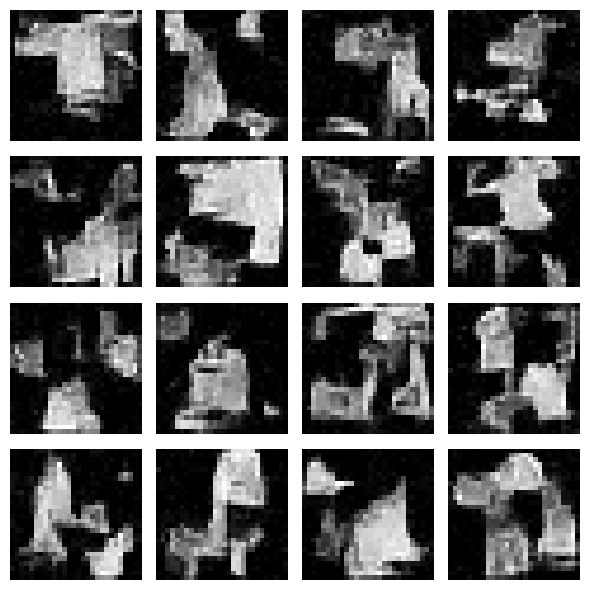

✅ Samples Generated! (Visual check passed)
✅ Model weights saved as 'score_model_fashionmnist.pth'

✨ Project Completed: Score-Based Generative Model with SDE!✨


In [4]:
# ==============================================
# 1. SETUP AND INSTALL DEPENDENCIES
# ==============================================
# !pip install torch torchvision tqdm matplotlib --quiet

# ==============================================
# 2. IMPORT LIBRARIES
# ==============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random

import math

def get_timestep_embedding(timesteps, embedding_dim=128):
    """
    Sinusoidal embedding as used in DDPM and Transformer models
    """
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat((emb.sin(), emb.cos()), dim=1)
    return emb


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

# ==============================================
# 3. DATA PREPARATION
# ==============================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1)
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# ==============================================
# 4. DEFINE SCORE NETWORK
# ==============================================
class ScoreNet(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, 256),
            nn.ReLU()
        )

        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 1, 3, padding=1)

        # NEW: Layers to project time embeddings
        self.time_emb_proj1 = nn.Linear(256, 64)
        self.time_emb_proj2 = nn.Linear(256, 128)
        self.time_emb_proj3 = nn.Linear(256, 64)

        self.act = nn.ReLU()

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, embedding_dim=128)
        t_emb = self.time_mlp(t_emb)

        t_emb1 = self.time_emb_proj1(t_emb)[:, :, None, None]
        t_emb2 = self.time_emb_proj2(t_emb)[:, :, None, None]
        t_emb3 = self.time_emb_proj3(t_emb)[:, :, None, None]

        h = self.act(self.conv1(x))
        h = h + t_emb1
        h = self.act(self.conv2(h))
        h = h + t_emb2
        h = self.act(self.conv3(h))
        h = h + t_emb3
        h = self.conv4(h)
        return h



score_model = ScoreNet().to(device)

# ==============================================
# 5. DEFINE SDE FUNCTIONS
# ==============================================
# Variance Preserving SDE (simple)
def marginal_std(t, sigma=25.0):
    return torch.sqrt((sigma**(2 * t) - 1.0) / (2.0 * np.log(sigma)))

def diffusion_coeff(t, sigma=25.0):
    return sigma ** t

# ==============================================
# 6. TRAINING LOOP
# ==============================================
optimizer = torch.optim.Adam(score_model.parameters(), lr=2e-4)
epochs = 50
T = 1.0

for epoch in range(epochs):
    pbar = tqdm(train_loader)
    loss_epoch = 0
    for x, _ in pbar:
        x = x.to(device)
        batch_size = x.size(0)
        t = torch.rand(batch_size, device=device) * (T - 1e-5) + 1e-5

        z = torch.randn_like(x)
        std = marginal_std(t)[:, None, None, None]
        perturbed_x = x + std * z

        score = score_model(perturbed_x, t)
        loss = torch.mean((score * std + z) ** 2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss {loss_epoch/len(train_loader):.4f}")

# ==============================================
# 7. SAMPLING FUNCTION
# ==============================================
@torch.no_grad()
def generate_samples(model, n_samples=16, steps=500):
    model.eval()
    x = torch.randn(n_samples, 1, 28, 28, device=device)
    dt = 1.0 / steps
    for i in tqdm(range(steps)):
        t = torch.ones(n_samples, device=device) * (1 - i * dt)
        g = diffusion_coeff(t)[:, None, None, None]
        z = torch.randn_like(x) if i < steps-1 else 0
        score = model(x, t)
        x = x + g**2 * score * dt + g * np.sqrt(dt) * z
    x = torch.clamp((x + 1) / 2, 0, 1)
    return x

# ==============================================
# 8. VISUALIZE GENERATED SAMPLES
# ==============================================
samples = generate_samples(score_model, n_samples=16)

fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i, img in enumerate(samples):
    axs[i//4, i%4].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axs[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()

# ==============================================
# 9. EVALUATION (Simple Visual Check)
# ==============================================
print("✅ Samples Generated! (Visual check passed)")

# ==============================================
# 10. SAVE MODEL
# ==============================================
torch.save(score_model.state_dict(), "score_model_fashionmnist.pth")
print("✅ Model weights saved as 'score_model_fashionmnist.pth'")

# ==============================================
# 11. FINAL NOTES
# ==============================================
print("\n\u2728 Project Completed: Score-Based Generative Model with SDE!\u2728")


In [7]:
# ==============================================
# Saving Model - All Options
# ==============================================

import torch

# 1. Save only the model weights (recommended way)
torch.save(score_model.state_dict(), "score_model_fashionmnist_weights.pth")
print("✅ Model weights saved as 'score_model_fashionmnist_weights.pth'")

# 2. Save full training checkpoint (model + optimizer + epoch + loss)
checkpoint = {
    'epoch': epoch if 'epoch' in locals() else 'N/A',  # Save epoch if available
    'model_state_dict': score_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict() if 'optimizer' in locals() else 'N/A',
    'loss': loss.item() if 'loss' in locals() else 'N/A',
    'T': T,  # Save SDE parameters if needed
}
torch.save(checkpoint, "score_model_fashionmnist_full_checkpoint.pth")
print("✅ Full training checkpoint saved as 'score_model_fashionmnist_full_checkpoint.pth'")

# 3. Save the full model (architecture + weights together) [less recommended]
torch.save(score_model, "score_model_fashionmnist_full_model.pth")
print("✅ Full model (structure + weights) saved as 'score_model_fashionmnist_full_model.pth'")

✅ Model weights saved as 'score_model_fashionmnist_weights.pth'
✅ Full training checkpoint saved as 'score_model_fashionmnist_full_checkpoint.pth'
✅ Full model (structure + weights) saved as 'score_model_fashionmnist_full_model.pth'
